# Programming Assignment 1

In this programming assignment, you will implement a linear regression model and a logistic regression model.

In Part 1, you have to implement a linear regression model to predict the price of a house based on various input features.

In Part 2, you have to implement a logistic regression model to predict the species of a grain using various morphological features.

The assignment zip file (ML_Assignment_1.zip) contains 4 datasets which will be used in this assignment.

You have to write your code in this jupyter notebook and submit the solved jupyter notebook with the file name \<Roll_No\>_A1.ipynb for evaluation. You have to enter your code only in those cells which are marked as ```## CODE REQUIRED ##```, and you have to write your code only between ```### START CODE HERE ###``` and ```### END CODE HERE ###``` comments.

## Part 1: Linear Regression

### Problem Statement  
A real estate company is building a machine learning model to determine the price of a house. The model will take various information regarding a house as input features and predict the price per unit area. They decided to use the linear regression as the machine learning model. Your task is to help the company to build the model.
Given various features of a house, you will create a linear regression model to predict the price of the house.

### Data Description

**For Even Roll Number Students:**

Dataset Filename: Taiwan_House.csv

Attributes Information:
1. Transaction date
2. House age
3. Distance to the nearest MRT station
4. Number of convenience stores
5. Latitude
6. Longitude

Target variable: house price of unit area

**For Odd Roll Number Students:**

Dataset Filename: Boston_House.csv

Attributes Information:
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-­retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million)
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner­occupied units built prior to 1940
8. DIS: weighted distances to five Boston employment centres
9. RAD: index of accessibility to radial highways
10. TAX: full-­value property-­tax rate per $10,000

11. PTRATIO: pupil-­teacher ratio by town
12. B: 1000(Bk ­- 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT: % lower status of the population

Target Variable: MEDV: Median value of owner-­occupied homes in $1000's


These are the following steps or functions that you have to complete to create and train the linear regression model:
1. Reading the data
2. Computing the loss function
3. Computing the gradient of the loss
4. Training the model using Batch Gradient Descent


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
import random

### 1.1. Reading the data

In the following function ```load_data```, you have to read the data from the file and store the data into a pandas dataframe. Then you have to create two numpy arrays $X$ and $y$ from the dataframe:

+ $X$: Input data of the shape (number of samples, number of input features)
+ $y$: Target variable of the shape (number of samples,)


In [2]:
def load_data(filepath):
    """
    This function loads the data into a pandas dataframe and coverts it into X and y numpy arrays

    Args:
        filepath: File path as a string
    Returns:
        X: Input data of the shape (# of samples, # of input features)
        y: Target variable of the shape (# of sample,)
    """
    ### START CODE HERE ###

    data = pd.read_csv(filepath)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    ### END CODE HERE ###

    return X, y

filepath = 'Boston_House.csv'
X, y = load_data(filepath)

print("Shape of X: ", X.shape, "Shape of y: ", y.shape)


Shape of X:  (506, 13) Shape of y:  (506,)


We will not use all the features from ```X```.

**For Even Roll Number Students:**
Set the last two digits of your roll number as the random seed and pick a number ``r`` between 3 and 6 (both inclusive) randomly. Use the first ```r``` features of the numpy array ```X```.

**For Odd Roll Number Students:**
Set the last two digits of your roll number as the random seed and pick a number ``r`` between 9 and 13 (both inclusive) randomly. Use the first ```r``` features of the numpy array ```X```.


In [3]:
def random_feature_selection(X):
    """
    For Even Roll Number Students: Set the last two digits of your roll number as the random seed and pick a number r
    between 3 and 6 randomly. Use the first ```r``` features of the numpy array X.
    For Odd Roll Number Students: Set the last two digits of your roll number as the random seed and pick a number r
    between 9 and 13 randomly. Use the first ```r``` features of the numpy array X.
    Args:
        X: Input data of the shape (# of samples, # of input features)
    Returns:
        X_new: New input data of the shape (# of samples, r) containg only the first r features from X
    """

    ### START CODE HERE ###

    random.seed(71)
    r = random.randint(9, 13)
    X_new = X[:, :r]

    # We can take random columns as well
    # X_new = X[:, np.random.randint(0, X.shape[1], r)]


    ### END CODE HERE ###
    
    return X_new

X = random_feature_selection(X)
print("Shape of X: ", X.shape, "Shape of y: ", y.shape)

Shape of X:  (506, 11) Shape of y:  (506,)


We need to pre-process the data. We are using min-max scaler to scale the input data ($X$).

After that, we split the data (```X``` and ```y```) into a training dataset (```X_train``` and ```y_train```) and test dataset (```X_test``` and ```y_test```).

In [4]:
def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def min_max_scaler(X, feature_range=(0, 1)):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    X_scaled = (X-X_min)/(X_max-X_min)
    return X_scaled

X = min_max_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Shape of X_train: ", X_train.shape, "Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape, "Shape of y_test: ", y_test.shape)


Shape of X_train:  (379, 11) Shape of y_train:  (379,)
Shape of X_test:  (127, 11) Shape of y_test:  (127,)


### 1.2. Computing the Loss Function

In linear regression, the model parameters are:

+ $w$: Parameters of the linear regression model (excluding the bias) of the shape (1, number of features)

+ $b$: Bias parameter (scalar) of the linear regression model

Both $w$ and $b$ are numpy arrays.

Given the model parameters $w$ and $b$, the prediction for an input sample $X^i$ is:
$$h_{w,b}(X^i) = w \cdot X^i + b$$
where $X^i$ is the $i^{th}$ training sample with shape (number of features,1)

For linear regression, you have to implement and compute Mean Squarred Error loss fucntion:
$$ L_{w,b}(X) = \sum_{i=1}^{m}(y^i - h_{w,b}(X^i))^2 $$
where $y^i$ is the true target value for the $i^{th}$ sample and $h_{w,b}(X^i)$ is the predicted value for the $i^{th}$ sample using the parameters $w$ and $b$.

$w$ is the list of parameters excluding the bias and $b$ is the bias term.

In [5]:
def loss_function(X, y, w, b):
    """
    Computes the cost function for linear regression.

    Args:
        X: Input data of the shape (# of training samples, # of input features)
        y: Target variable of the shape (# of training sample,)
        w: Parameters of the linear regression model (excluding the bias) of the shape (1, number of features)
        b: Bias parameter (scalar) of the linear regression model

    Returns
        loss: The loss function value of using w and b as the parameters to fit the data points in X and y
    """
    # number of training examples
    m = X.shape[0]

    ### START CODE HERE ###

    predictions = np.dot(X, w) + b
    squared_errors = (y - predictions) ** 2
    loss = np.sum(squared_errors)/m

    ### END CODE HERE ###

    
    return loss

### 1.3. Comptuing the Gradient of the Loss

In this following function ```compute_gradient```, you have to compute the gradients $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$ of the loss $L$ w.r.t. $w$ and $b$. More specifically, you have to iterate over every training example and compute the gradients of the loss for that training example. Finally, aggregate the gradient values for all the training examples and take the average. The gradients can be computed as:
$$\frac{\partial L}{\partial w} = \frac{1}{m} \sum_{i=1}^m (h_{w,b}(X^i)-y^i)X^i$$

$$\frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (h_{w,b}(X^i)-y^i)$$


In [6]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient values
    Args:
       X: Input data of the shape (# of training samples, # of input features)
       y: Target variable of the shape (# of training sample,)
       w: Parameters of the linear regression model (excluding the bias) of the shape (1, number of features)
       b: Bias parameter of the linear regression model of the shape (1,1) or a scaler
    Returns:
       dL_dw : The gradient of the cost w.r.t. the parameters w with shape same as w
       dL_db : The gradient of the cost w.r.t. the parameter b with shape same as b
    """

    # Number of training examples
    m = X.shape[0]

    ### START CODE HERE ###
    
    predictions = np.dot(X, w) + b

    error = predictions - y
    dL_dw = np.dot(X.T, error) / m
    dL_db = np.sum(error) / m

    ### END CODE HERE ###

    return dL_dw, dL_db


### 1.4. Training the Model using Batch Gradient Descent

Finally, you have to implement the batch gradient descent algorithm to train and learn the parameters of the linear regression model. You have to use ```loss_function``` and ```compute_gradient``` functions that you have implemented earlier in this assignment.

In this ```batch_gradient_descent``` function, you have to compute the gradient for the training samples and update the parameters $w$ and $b$ in every iteration:

+ $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$

+ $b \leftarrow b - \alpha \frac{\partial L}{\partial b}$

Additionally, you have compute the loss function values in every iteration and store it in the list variable ```loss_hist``` and print the loss value after every 100 iterations during the training process.

In [7]:
def batch_gradient_descent(X, y, w_initial, b_initial, alpha, num_iters, printFlag = False):
    """
    Batch gradient descent to learn the parameters (w and b) of the linear regression model and to print loss values
    every 100 iterations.

    Args:
        X: Input data of the shape (# of training samples, # of input features)
        y: Target variable of the shape (# of training sample,)
        w_initial: Initial parameters of the linear regression model (excluding the bias) of the shape (number of features,)
        b_initial: Initial bias parameter (scalar) of the linear regression model
        alpha: Learning rate
        num_iters: number of iterations

    Returns:
        w: Updated values of parameters of the model after training
        b: Updated bias of the model after training
        loss_hist: List of loss values for every iteration
    """

    # Number of training examples
    m = X.shape[0]

    # to store loss values for every iteation as a list and print loss value after every 100 iterations
    loss_hist = []

    # Initialize parameters
    w = copy.deepcopy(w_initial) ## deepcopy is used so that the updates do not change the initial variable values
    b = b_initial

    ### START CODE HERE ###

    for i in range(num_iters):
        dL_dw, dL_db = compute_gradient(X, y, w, b)

        w -= alpha * dL_dw
        b -= alpha * dL_db
        loss = loss_function(X, y, w, b)
        
        loss_hist.append(loss)

        if printFlag and i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss}")

    ### END CODE HERE ###

    return w, b, loss_hist


Now you have to intialize the model parameters ($w$ and $b$) and learning rate (```alpha```). The learning rate ```alpha``` has to be randomly initialized between 0.0001 and 0.001. For the learning rate, you have to first set the last two digits of your roll number as the random seed using ```random.seed()``` function.

In [8]:
# Set the random seed for reproducibility
random_seed = 71
random.seed(random_seed)
np.random.seed(random_seed)

def initialize_parameters(X):
    """
    This function randomly initializes the model parameters (w and b) and the hyperparameter alpha.
    Initial w and b are sampled from a normal distribution with mean 0.
    Alpha is randomly initialized between 0.0001 and 0.001.
    
    Args:
        X: Input data of the shape (# of training samples, # of input features)

    Returns:
        initial_w: Initial parameters of the linear regression model (excluding the bias) of the shape (number of features,)
        initial_b: Initial bias parameter (scalar) of the linear regression model
        alpha: Learning rate
    """
    ### START CODE HERE ###

    alpha = random.uniform(0.0001, 0.001)
    num_features = X.shape[1]
    initial_w = np.random.randn(num_features)
    initial_b = 0

    ### END CODE HERE ###

    return initial_w, initial_b, alpha

In the next cell, the model is trained using batch gradient descent algorithm for ```num_iters=10000``` iterations. You can change the number of iterations to check any improvements in the performance.

In [9]:
# initialize the parameters and hyperparameter
initial_w, initial_b, alpha = initialize_parameters(X_train)

# number of iterations
num_iters = 10000

w,b,loss_hist = batch_gradient_descent(X_train ,y_train, initial_w, initial_b, alpha, num_iters, True)

print("Updated w: ",w)
print("Updated b: ",b)

Iteration 0: Loss = 597.2067664354943
Iteration 100: Loss = 505.33269202060666
Iteration 200: Loss = 431.8361089040912
Iteration 300: Loss = 372.9700397089757
Iteration 400: Loss = 325.7529860450158
Iteration 500: Loss = 287.812514470307
Iteration 600: Loss = 257.2608039941867
Iteration 700: Loss = 232.59562410605082


Iteration 800: Loss = 212.62154686149583
Iteration 900: Loss = 196.3872584028738
Iteration 1000: Loss = 183.13568015961224
Iteration 1100: Loss = 172.26428220165388
Iteration 1200: Loss = 163.29350608438224
Iteration 1300: Loss = 155.84164009417486
Iteration 1400: Loss = 149.60482841341903
Iteration 1500: Loss = 144.3411651420611
Iteration 1600: Loss = 139.85803847810956
Iteration 1700: Loss = 136.00206092147374
Iteration 1800: Loss = 132.65105707487675
Iteration 1900: Loss = 129.70768859410052
Iteration 2000: Loss = 127.09438175403061
Iteration 2100: Loss = 124.74929145547614
Iteration 2200: Loss = 122.62308988788207
Iteration 2300: Loss = 120.67641133911738
Iteration 2400: Loss = 118.8778190765666
Iteration 2500: Loss = 117.20218762075044
Iteration 2600: Loss = 115.62941553140146
Iteration 2700: Loss = 114.14340117027932
Iteration 2800: Loss = 112.73122770522417
Iteration 2900: Loss = 111.38251460022734
Iteration 3000: Loss = 110.08890157287145
Iteration 3100: Loss = 108.843637951833

### 1.5. Final Train Error and Test Error

After the linear regression model is trained, we will compute the final train error and test error for the trained model.

In [10]:
## Train and Test error computation

train_error = loss_function(X_train,y_train,w,b)
test_error = loss_function(X_test,y_test,w,b)
print("Train Error: ",train_error, ", Test Error: ",test_error)

Train Error:  66.08153782432943 , Test Error:  58.54817310925999


### 1.6. Plotting the loss function

We will plot the loss function values for every training iteration. If the model is trained properly, you will see that the loss function reduces as the training progesses and it converges at some point.

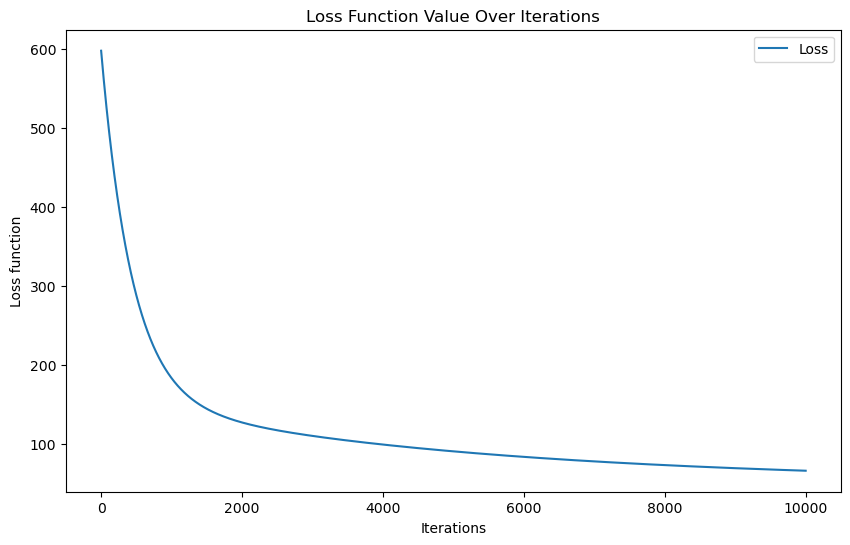

In [11]:
# PLotting the loss values for every training iterations
loss_plot = loss_hist #Directly assigning it because it is a list of scalar data i.e., loss.

# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(loss_plot, label="Loss")
plt.title("Loss Function Value Over Iterations")
plt.legend()
plt.show()


### 1.7 Experimenting with different values of the Hyperparemeters

Previously, we randomly sampled the learning rate and the number of features to train the model. Now, you have to manually choose the number of features and the learning rate. Then, you have to train the model again on the manually choosen hyperparameters (number of features and learning rate). In the next cell, you have to manually choose the hyperparameters and write the code to train the model.

After the model is trained, you have to compare the performance of the model with random chosen hyperparameters and manually chosen hyperparameters.

In [12]:
# Manually choosing the number of features and learning rate
num_features = 11
learning_rate = 0.1

# Adjust the number of features in X_train and X_test
X_train = X_train[:, :num_features]
X_test = X_test[:, :num_features]

# Initialize parameters with chosen learning rate and number of features
initial_w = np.zeros(num_features)  # Or any other initialization method
initial_b = 0

# Train the model using batch gradient descent with manually chosen hyperparameters
num_iters = 1000
w, b, loss_hist = batch_gradient_descent(X_train, y_train, initial_w, initial_b, learning_rate, num_iters)

# Compute train and test errors with manually chosen hyperparameters
train_error_manual = loss_function(X_train, y_train, w, b)
test_error_manual = loss_function(X_test, y_test, w, b)

print("\nComparison of Performance:")
print("Randomly Chosen Hyperparameters:")
print("Train Error: ", train_error)
print("Test Error: ", test_error)

print("\nManually Chosen Hyperparameters:")
print("Train Error: ", train_error_manual)
print("Test Error: ", test_error_manual)

# Calculating % performace of which model performed better
train_error_diff = (train_error - train_error_manual) / train_error * 100
test_error_diff = (test_error - test_error_manual) / test_error * 100

train_perf = "Manual" if train_error_manual < train_error else "Random"
test_perf = "Manual" if test_error_manual < test_error else "Random"

print(f"\nPerformance Comparison:")
print(f"Train Error Difference: {train_error_diff:.2f}% ({train_perf} performed better)")
print(f"Test Error Difference: {test_error_diff:.2f}% ({test_perf} performed better)")



Comparison of Performance:
Randomly Chosen Hyperparameters:
Train Error:  66.08153782432943
Test Error:  58.54817310925999

Manually Chosen Hyperparameters:
Train Error:  30.056539536785674
Test Error:  28.380108369570134

Performance Comparison:
Train Error Difference: 54.52% (Manual performed better)
Test Error Difference: 51.53% (Manual performed better)


## Part 2: Logistic Regression

### Problem Statement
A Food grain industry requires an efficient classification system to help in sorting food grain species. You have to develop a Logistic Regression model for this purpose.
 Given various features of a rice grain such as area, perimeter, axis lengths etc. as input features, the task is to build a logistic regression model to predict the species of the food grain.

### Dataset Description

**For Even Roll Number Students**

Dataset Filename: Rice_Classification.csv

Attribute Information:
+ Area: Returns the number of pixels within the boundaries of the rice grain.
+ Perimeter: Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain.
+ Major Axis Length: The longest line that can be drawn on the rice grain, i.e. the main axis distance, gives.
+ Minor Axis Length: The shortest line that can be drawn on the rice grain, i.e. the small axis distance, gives.
+ Eccentricity: It measures how round the ellipse, which has the same moments as the rice grain, is.
+ Convex Area: Returns the pixel count of the smallest convex shell of the region formed by the rice grain.
+ Extent: Returns the ratio of the region formed by the rice grain to the bounding box pixels.

Target Variable: Class: Cammeo and Osmancik

**For Odd Roll Number Students**

Dataset Filename: Pumpkin_Seeds_Dataset.csv

Attribute Information:

+ Area: Represents the number of pixels within the boundaries of the pumpkin seed.

+ Perimeter: Calculates the circumference by measuring the distance between pixels around the boundary of the pumpkin seed.

+ Major Axis Length: The longest line that can be drawn on the pumpkin seed, representing the main axis distance.

+ Minor Axis Length: The shortest line that can be drawn on the pumpkin seed, representing the minor axis distance.

+ Convex Area: Returns the pixel count of the smallest convex shell that can contain the pumpkin seed.

+ Equivalent Diameter: Diameter of a circle with the same area as the pumpkin seed.

+ Eccentricity: This measures how round the ellipse, which has the same moments as the pumpkin seed has.

+ Solidity: This is the ratio of the area of the pumpkin seed to the area of its convex hull. It measures the extent to which the shape is convex.

+ Extent: Returns the ratio of the area of the pumpkin seed to the area of its bounding box.

+ Roundness: Measure of how closely the shape of the pumpkin seed approaches that of a circle.

+ Aspect Ratio: Ratio of the major axis length to the minor axis length.

+ Compactness: Measure of the shape's compactness, which is the shape's deviation from being a perfect circle. In essence, compactness quantifies how efficiently an object's area is packed within its perimeter.

Target Variable: Class: Çerçevelik and Ürgüp Sivrisi



These are the following steps or functions that you have to complete to create and train the linear regression model:
1. Reading the data
2. Creating the sigmoid function
2. Computing the loss function
3. Computing the gradient of the loss
4. Training the model using Batch Gradient Descent

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import copy
import math

### 2.1. Reading the data

In the function ```load_data```, you have to read data from the file, store it in a dataframe and split the data from the dataframe into two numpy arrays X and y.

**X** : data of the input features

**y**  : data of the class labels

The class labels in **y** should be replaced with '0' and '1', for corresponding classes.

In [14]:
## CODE REQUIRED ##
def load_data(filepath):
    """
    This function loads the data into a pandas dataframe and converts it into X and y numpy arrays
    y should be a binary numpy array with values 0 and 1, for 2 different classes
    Args:
        filepath: File path as a string
    Returns:
        X: Input data of the shape (# of samples, # of input features)
        y: Target variable of the shape (# of sample,) with values 0 and 1, for 2 different classes
    """

    ### START CODE HERE ###

    df = pd.read_csv(filepath)
    
    X = df.drop('Class', axis=1).values
    y = df['Class'].values
    
    unique_classes = np.unique(y)
    class_map = {label: idx for idx, label in enumerate(unique_classes)}
    y = np.array([class_map[label] for label in y])

    ### END CODE HERE ###
    
    return X, y

## set the file path
filepath = 'Pumpkin_Seeds_Dataset.csv'

X, y = load_data(filepath)

print("Shape of X: ",X.shape, "Shape of y: ",y.shape)


Shape of X:  (2500, 12) Shape of y:  (2500,)


We will not use all the features from X.

For Even Roll Number Students: Set the last two digits of your roll number as the random seed and pick a number r between 4 and 7 (both inclusive) randomly. Use the first r features of the numpy array X.

For Odd Roll Number Students: Set the last two digits of your roll number as the random seed and pick a number r between 8 and 12 (both inclusive) randomly. Use the first r features of the numpy array X.

In [15]:
## CODE REQUIRED ##

def random_feature_selection(X):
    """

    Args:
        X: Input data of the shape (# of samples, # of input features)
    Returns:
        X_new: New input data of the shape (# of samples, r) containg only the first r features from X
    """

    ### START CODE HERE ###

    np.random.seed(71)
    r = np.random.randint(8, 13)
    X_new = X[:, :r] # Selecting the first r features

    ### END CODE HERE ###
    
    return X_new

X = random_feature_selection(X)
print("Shape of X: ", X.shape, "Shape of y: ", y.shape)

Shape of X:  (2500, 11) Shape of y:  (2500,)


We need to pre-process the data. We are using min-max scaler to scale the input data ($X$).

After that, we split the data (```X``` and ```y```) into a training dataset (```X_train``` and ```y_train```) and test dataset (```X_test``` and ```y_test```)

In [16]:
## Data scaling and train-test split

def train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    split_index = int(X.shape[0] * (1 - test_size))

    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

def min_max_scaler(X, feature_range=(0, 1)):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    X_scaled = (X-X_min)/(X_max-X_min)

    return X_scaled

# Feature normalization
X = min_max_scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Shape of X_train: ",X_train.shape, "Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape, "Shape of y_test: ",y_test.shape)

Shape of X_train:  (1875, 11) Shape of y_train:  (1875,)
Shape of X_test:  (625, 11) Shape of y_test:  (625,)


### 2.2. Creating the Sigmoid Function
Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$


The function below returns the value of the sigmoid function for an input numpy array z. If the numpy array 'z' stores multiple numbers, we'd like to apply the sigmoid function to each value in the input array

In [17]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z: A scalar or numpy array of any size.

    Returns:
        g: sigmoid(z)
    """
    z = z.astype(float)
    g = 1 / (1 + np.exp(-z))
    
    return g


### 2.3. Computing the loss Function

Recall that for logistic regression, the cost function is of the form

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is -

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.

Please complete the function loss_function that takes

 **X**  (input features)

 **y**  (class labels)

 **w**  (Parameters of the logistic regression model, (excluding the bias), a numpy array of the shape(1, number of features))

 **b**  (Bias value of the logistic regression model)

 You can use the Sigmoid function that you implemented above.

In [18]:
def loss_function(X, y, w, b):
    """
    Computes the loss function for all the training examples
    Args:
            X: Input data of the shape (# of training samples, # of input features)
            y: Target variable of the shape (# of training sample,)
            w: Parameters of the logistic regression model (excluding the bias) of the shape (1, number of features)
            b: Bias parameter (scalar) of the logistic regression model

    Returns:
            total_cost: The loss function value of using w and b as the parameters to fit the data points in X and y

    """
    
    m, n = X.shape

    # Compute the predictions using the sigmoid function
    z = np.dot(X, w) + b
    y_pred = sigmoid(z)
    
    # Compute the cost using the logistic loss formula
    cost = - (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
    
    # Compute the total cost
    total_cost = np.sum(cost) / m
    
    return total_cost


### 2.4. Computing the Gradient of the Loss

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

In this step, you are required to complete the `compute_gradient_logistic_regression` function to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label

You can use the sigmoid function that you implemented above.

In [19]:
def compute_gradient_logistic_regression(X, y, w, b):
    """
    Computes the gradient values of the loss function
    Args:
       X: Input data of the shape (# of training samples, # of input features)
       y: Target variable of the shape (# of training sample,)
       w: Parameters of the logistic regression model (excluding the bias) of the shape (1, number of features)
       b: Bias parameter of the logistic regression model of the shape (1,1) or a scaler
    Returns:
       dL_dw : The gradient of the cost w.r.t. the parameters w with shape same as w
       dL_db : The gradient of the cost w.r.t. the parameter b with shape same as b
    """
    m, n = X.shape
    
    # Compute predictions using the sigmoid function
    z = np.dot(X, w) + b
    y_pred = sigmoid(z)
    
    # Compute the gradient of the cost w.r.t. the bias
    dL_db = np.sum(y_pred - y) / m
    
    # Compute the gradient of the cost w.r.t. the weights
    dL_dw = np.dot(X.T, (y_pred - y)) / m
    
    return dL_db, dL_dw


### 2.5. Training the model using Batch Gradient Descent

Please complete the batch gradient descent algorithm for logistic regression to train and learn the parameters of the logistic regression model. You have to use ```loss_function``` and ```compute_gradient_logistic regression``` functions that you have implemented earlier in this assignment.

In this ```batch_gradient_descent_logistic_regression``` function, you have to compute the gradient for the training samples and update the parameters $w$ and $b$ in every iteration:

+ $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$

+ $b \leftarrow b - \alpha \frac{\partial L}{\partial b}$

This function takes   ```X```    (input features),  ```y```  (class labels),  ```w_in```  (intial values of parameters(excluding bias)),  ```b_in```  (initial value for bias),  ```num_iters```   (number of iterations of training) as input.

Additionally, you have compute the loss function values in every iteration and store it in the list variable ```loss_hist``` and print the loss value after every 100 iterations during the training process.

In [20]:
def batch_gradient_descent_logistic_regression(X, y, w_in, b_in, alpha, num_iters, printFlag = False):
    """
    Batch gradient descent to learn the parameters (w and b) of the linear regression model and to print loss values
    every 100 iterations

    Args:
        X: Input data of the shape (# of training samples, # of input features)
        y: Target variable of the shape (# of training sample,)
        w_in: Initial parameters of the logistic regression model (excluding the bias) of the shape (1, number of features)
        b_in: Initial bias parameter (scalar) of the logistic regression model
        alpha: Learning rate
        num_iters: number of iterations
    Returns
        w: Updated values of parameters of the model after training
        b: Updated bias of the model after training
        loss_hist: List of loss values for every iteration
    """
    w = np.copy(w_in)
    b = b_in

    loss_hist = []

    for i in range(num_iters):
        # Compute the gradients
        dL_db, dL_dw = compute_gradient_logistic_regression(X, y, w, b)

        # Update the parameters
        w -= alpha * dL_dw
        b -= alpha * dL_db

        # Compute the loss and store it
        loss = loss_function(X, y, w, b)
        loss_hist.append(loss)

        # Print the loss every 100 iterations
        if printFlag and i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss}")

    return w, b, loss_hist


Now you have to intialize the model parameters ($w$ and $b$) and learning rate (```alpha```). The learning rate ```alpha``` has to be randomly initialized between 0.01 and 0.09. To randomly initialize the learning rate, you have to first set the last two digits of your roll number as the random seed using ```random.seed()``` function.

In [21]:
# set the last two digits of your roll number as the random seed
random_seed = 71
random.seed(random_seed)
np.random.seed(random_seed)

def initialize_parameters(num_features):
    """
    This function randomly initializes the model parameters (w and b) and the hyperparameter alpha.
    Initial w and b are sampled from a normal distribution with mean 0.
    Alpha is randomly initialized between 0.01 and 0.09.

    Args:
        num_features: Number of features in the dataset.

    Returns:
        initial_w: Initial parameters of the logistic regression model (excluding the bias) of shape (num_features,).
        initial_b: Initial bias parameter (scalar) of the logistic regression model.
        alpha: Learning rate.
    """

    # Randomly initialize parameters w and b
    initial_w = np.random.normal(0, 1, num_features)
    initial_b = np.random.normal(0, 1)
    
    # Randomly initialize alpha between 0.01 and 0.09
    alpha = random.uniform(0.01, 0.09)

    return initial_w, initial_b, alpha


The following cell runs the batch gradient algorithm for
```num_iterations=1000``` to train the logistic regression model. You can change the number of iterations to check any improvements in the performance

In [22]:
num_features = X_train.shape[1]  # Number of features in the dataset
initial_w, initial_b, alpha = initialize_parameters(num_features)
num_iterations = 1000

# Train the logistic regression model using batch gradient descent
w, b, loss_hist = batch_gradient_descent_logistic_regression(X_train, y_train, initial_w, initial_b, alpha, num_iterations, True)

# Print the optimized parameter values
print("Optimized parameter values w:", w)
print("Optimized parameter value b:", b)

Iteration 0: Loss = 0.7474725983480304
Iteration 100: Loss = 0.6807320129330692
Iteration 200: Loss = 0.6451225966787664
Iteration 300: Loss = 0.6150371891324535
Iteration 400: Loss = 0.5895061932581874
Iteration 500: Loss = 0.5677155496232856
Iteration 600: Loss = 0.5489944820970061
Iteration 700: Loss = 0.5327986370093635
Iteration 800: Loss = 0.5186896030859068
Iteration 900: Loss = 0.5063151075099972
Optimized parameter values w: [-0.13512646 -0.48585181  0.6739125  -0.44162182 -0.1682412   0.84331902
  1.70991658 -1.25211161 -0.49966957 -2.35523088  0.97048908]
Optimized parameter value b: 0.9514887122860507


### 2.6. Final Train and Test Accuracy
After the logistic regression model is trained, we will predict the class labels for the training set and test set and we will compute the accuracy.

Please complete the `predict` function to produce `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example

- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [23]:
def predict(X, w, b):
    m, n = X.shape
    p = np.zeros(m)

    # Compute the model's prediction f(x) = g(w . x + b)
    z = np.dot(X, w) + b
    f_x = sigmoid(z)

    # Convert probabilities to binary predictions
    p = (f_x >= 0.5).astype(int)

    return p


Now let's use this to compute the accuracy on the training and test datasets

In [24]:
p_train = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p_train == y_train) * 100))
p_test = predict(X_test, w,b)
print('Test Accuracy: %f'%(np.mean(p_test == y_test) * 100))

Train Accuracy: 84.266667
Test Accuracy: 84.960000


Now, we plot the loss function values for every iteration.

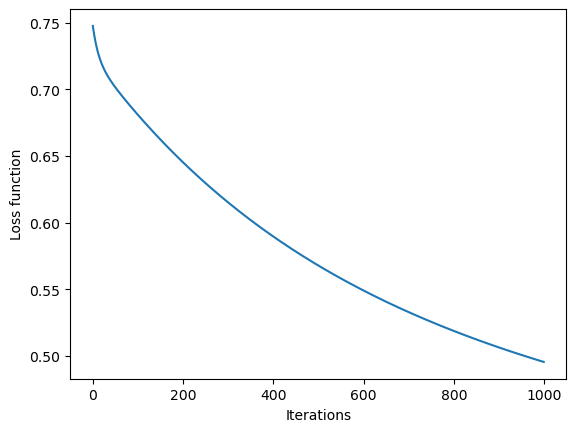

In [25]:
# PLotting the loss values for every training iterations

loss_plot = [loss_hist[i] for i in range(len(loss_hist))]
plt.xlabel("Iterations")
plt.ylabel("Loss function")
plt.plot(loss_plot)
plt.show()

### 2.7 Experimenting with different values of the Hyperparemeters

Previously, we randomly sampled the learning rate and the number of features to train the model. Now, you have to manually choose the number of features and the learning rate. Then, you have to train the model again on the manually choosen hyperparameters (number of features and learning rate). In the next cell, you have to manually choose the hyperparameters and write the code to train the model.

After the model is trained, you have to compare the performance of the model with random chosen hyperparameters and the model **with** manually chosen hyperparameters.

In [26]:
no_of_features = 10
alpha = 0.1
X = X[:, :no_of_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Training the model with manually chosen hyperparameters
initial_w = np.random.normal(0, 1, no_of_features)
initial_b = np.random.normal(0, 1)

w, b, loss_hist = batch_gradient_descent_logistic_regression(X_train, y_train, initial_w, initial_b, alpha, num_iterations)

# Calculate and print the accuracy with manually chosen hyperparameters
p_train_manual = predict(X_train, w, b)
p_test_manual = predict(X_test, w, b)
train_accuracy_manual = np.mean(p_train_manual == y_train) * 100
test_accuracy_manual = np.mean(p_test_manual == y_test) * 100


print("\nPerformance with Manual Hyperparameters:")
print(f"Train Accuracy: {train_accuracy_manual:.2f}%")
print(f"Test Accuracy: {test_accuracy_manual:.2f}%")

train_accuracy_random = np.mean(p_train == y_train) * 100
test_accuracy_random = np.mean(p_test == y_test) * 100

print("\nPerformance with Random Hyperparameters:")
print(f"Train Accuracy: {train_accuracy_random:.2f}%")
print(f"Test Accuracy: {test_accuracy_random:.2f}%")

# Calculate percentage improvement for training accuracy
train_accuracy_improvement = ((train_accuracy_manual - train_accuracy_random) / train_accuracy_random) * 100

# Calculate percentage improvement for testing accuracy
test_accuracy_improvement = ((test_accuracy_manual - test_accuracy_random) / test_accuracy_random) * 100

# Determine which performed better for training accuracy
train_perf = "Manual" if train_accuracy_improvement > 0 else "Random"
print(f"\nTrain Accuracy Improvement: {abs(train_accuracy_improvement):.2f}% ({train_perf} performed better)")

# Determine which performed better for testing accuracy
test_perf = "Manual" if test_accuracy_improvement > 0 else "Random"
print(f"Test Accuracy Improvement: {abs(test_accuracy_improvement):.2f}% ({test_perf} performed better)")


Performance with Manual Hyperparameters:
Train Accuracy: 84.16%
Test Accuracy: 86.08%

Performance with Random Hyperparameters:
Train Accuracy: 84.27%
Test Accuracy: 84.96%

Train Accuracy Improvement: 0.13% (Random performed better)
Test Accuracy Improvement: 1.32% (Manual performed better)
